In [1]:
import numpy as np
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn  


## Оценка стоимости бриллианта
## 1. **Загружаем Данные**

In [2]:
url = "https://raw.githubusercontent.com/kustuk1306/ML-lab/main/diamonds_data.csv"
data_raw = pd.read_csv(url)
data_new = data_raw.iloc[:, 0:11]
data_new

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


Мы видим, что столбцы (признаки) имеют имена

- carat - Значение карат бриллианта
- cut - Тип обрезки бриллианта (определяет блеск)
- color - Цвет бриллианта (в диапазоне от I1 - худший, IF - лучший)
- clarity - Тип брилианта в каратах (в диапазоне от J - худший, D - лучший) 
- depth - Значение глубины бриллианта
- table - Ширина вершины ромба относительно самого широкого конца
- price - Цена бриллианта
- x - Длина в мм
- y - Ширина в мм
- z - Глубина в мм

Столбцы 'cut' , 'color' и 'clarity' содержат категориальные значения. Пока они имеют тип 'Object'. Заменим тип на специальный, предназначенный для хранения категориальных значений:

In [3]:
data_new['cut'] = data_new['cut'].astype('category')
data_new['color'] = data_new['color'].astype('category')
data_new['clarity'] = data_new['clarity'].astype('category')

In [4]:
data_new.loc[:, ['cut', 'color', 'clarity']]

,cut,color,clarity
0,Ideal,E,SI2
1,Premium,E,SI1
2,Good,E,VS1
3,Premium,I,VS2
4,Good,J,SI2
...,...,...,...
53935,Ideal,D,SI1
53936,Good,D,SI1
53937,Very Good,D,SI1
53938,Premium,H,SI2


## 2. Боремся с выбросами (outliers)

Цена бриллианта в первую очередь зависит от числа карат. Поэтому построим диаграмму рассеивания для двух признаков: carat и price.

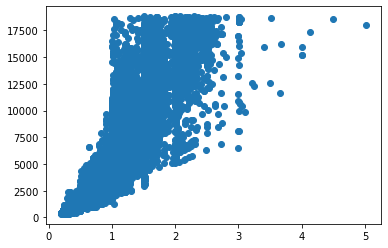

In [5]:
plt.scatter(data_new['carat'], data_new['price'])
pass

Мы видим, что основная масса точек сгрудилась от 0 до ~2.5 по x. Какие-то точки соответствуют квартирам с чрезмерно большими значениями карат. Например, более 3. Это выбросы (outliers) - объекты, значения признаков которых сильно отличаются от признаков основной массы объектов, сильно выпадающих из общей картины.

In [6]:
data_new['price'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005      402.00
0.010      429.00
0.050      544.00
0.100      646.00
0.500     2401.00
0.900     9821.00
0.950    13107.10
0.990    17378.22
0.995    18093.66
Name: price, dtype: float64

Мы видим, например, что $99.9\%$ всех значений признака 'price' находится в диапазоне от $400$ до $18100$ (это значения квантилей, соответствующих уровням $0.005$ и $0.995$ соотвтетственно)

In [7]:
data_new['carat'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005    0.23
0.010    0.24
0.050    0.30
0.100    0.31
0.500    0.70
0.900    1.51
0.950    1.70
0.990    2.18
0.995    2.31
Name: carat, dtype: float64

Мы видим, например, что $99.9\%$ всех значений признака 'carat' находится в диапазоне от $0.23$ до $2.31$ (это значения квантилей, соответствующих уровням $0.005$ и $0.995$ соотвтетственно).

Удалим все строки таблицы, в которых 'price' или 'carat' выходят за пределы квантилей $0.005$, $0.995$.

In [8]:
rows_to_drop = data_new[
    (data_new['price'] < data_new['price'].quantile(0.005)) | (data_new['price'] > data_new['price'].quantile(0.995)) | 
    (data_new['carat']  < data_new['carat' ].quantile(0.005)) | (data_new['carat']  > data_new['carat' ].quantile(0.995))].index
data = data_new.drop(rows_to_drop)
data.shape

(53184, 10)

## 3. Визуальная и описательная статистика

In [9]:
data.describe()

,carat,depth,table,price,x,y,z
count,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000
mean,0.786504,61.748451,57.451384,3830.148466,5.713838,5.717375,3.528204
std,0.451083,1.427690,2.231588,3802.382623,1.092347,1.114457,0.687762
min,0.230000,43.000000,43.000000,402.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,955.000000,4.720000,4.730000,2.910000
50%,0.700000,61.800000,57.000000,2391.000000,5.690000,5.700000,3.520000
75%,1.040000,62.500000,59.000000,5241.000000,6.530000,6.520000,4.030000
max,2.310000,79.000000,95.000000,18077.000000,8.800000,58.900000,31.800000


Проанализиров строку count можно убедиться, что в наших данных нет пропусков.

Получим информацию о категориальных признаках:

In [10]:
data_describe = data.describe(include=['category'])
data_describe

,cut,color,clarity
count,53184,53184,53184
unique,5,7,8
top,Ideal,G,SI1
freq,21336,11177,12893


Построим снова диаграмму рассеивания для признаков 'carat' и 'price'.

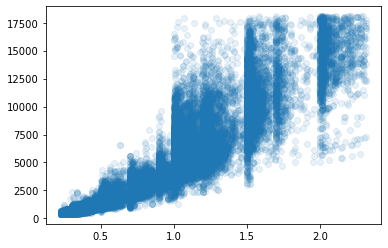

In [11]:
plt.scatter(data['carat'], data['price'], alpha=0.1)
pass

Изобразим $1000$ случайных точек:

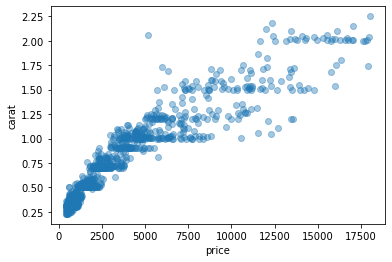

In [12]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.scatter(data.iloc[random_subset]['price'], data.iloc[random_subset]['carat'], alpha=0.4)
plt.xlabel('price')
plt.ylabel('carat')
pass

В следующей диаграмме цвет маркеров соответствует цвету бриллианта 'color', а размер - значению глубины 'depth':

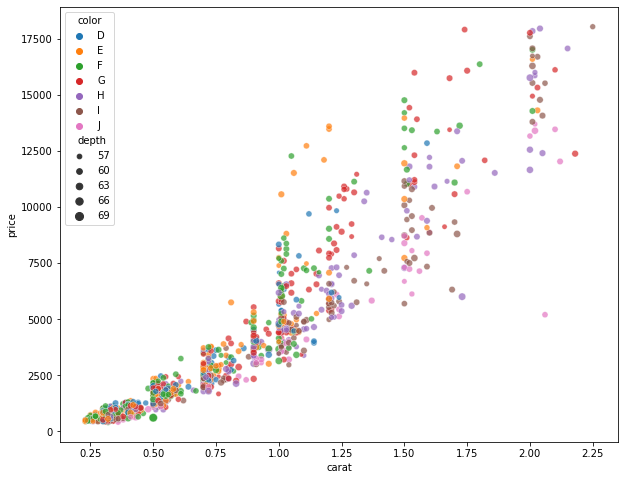

In [13]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.figure(figsize = (10, 8))
sns.scatterplot(x='carat', y='price', size='depth', hue='color', data=data.iloc[random_subset], alpha=0.7)
pass

Мы видим, что цена зависит от каждого из принзнака примерно одинакого. Но наблюдается возрастание цены от увелечения карата. Так же мы видим, что цвет сильнее влияет на цену, чем размер алмаза. К примеру мы можем увидеть, что бриллиант лучшего цвета, но меньшей глубины стоит дороже при равном значении карат.

Построим все возможные диаграммы рассеивания для каждой пары переменных:

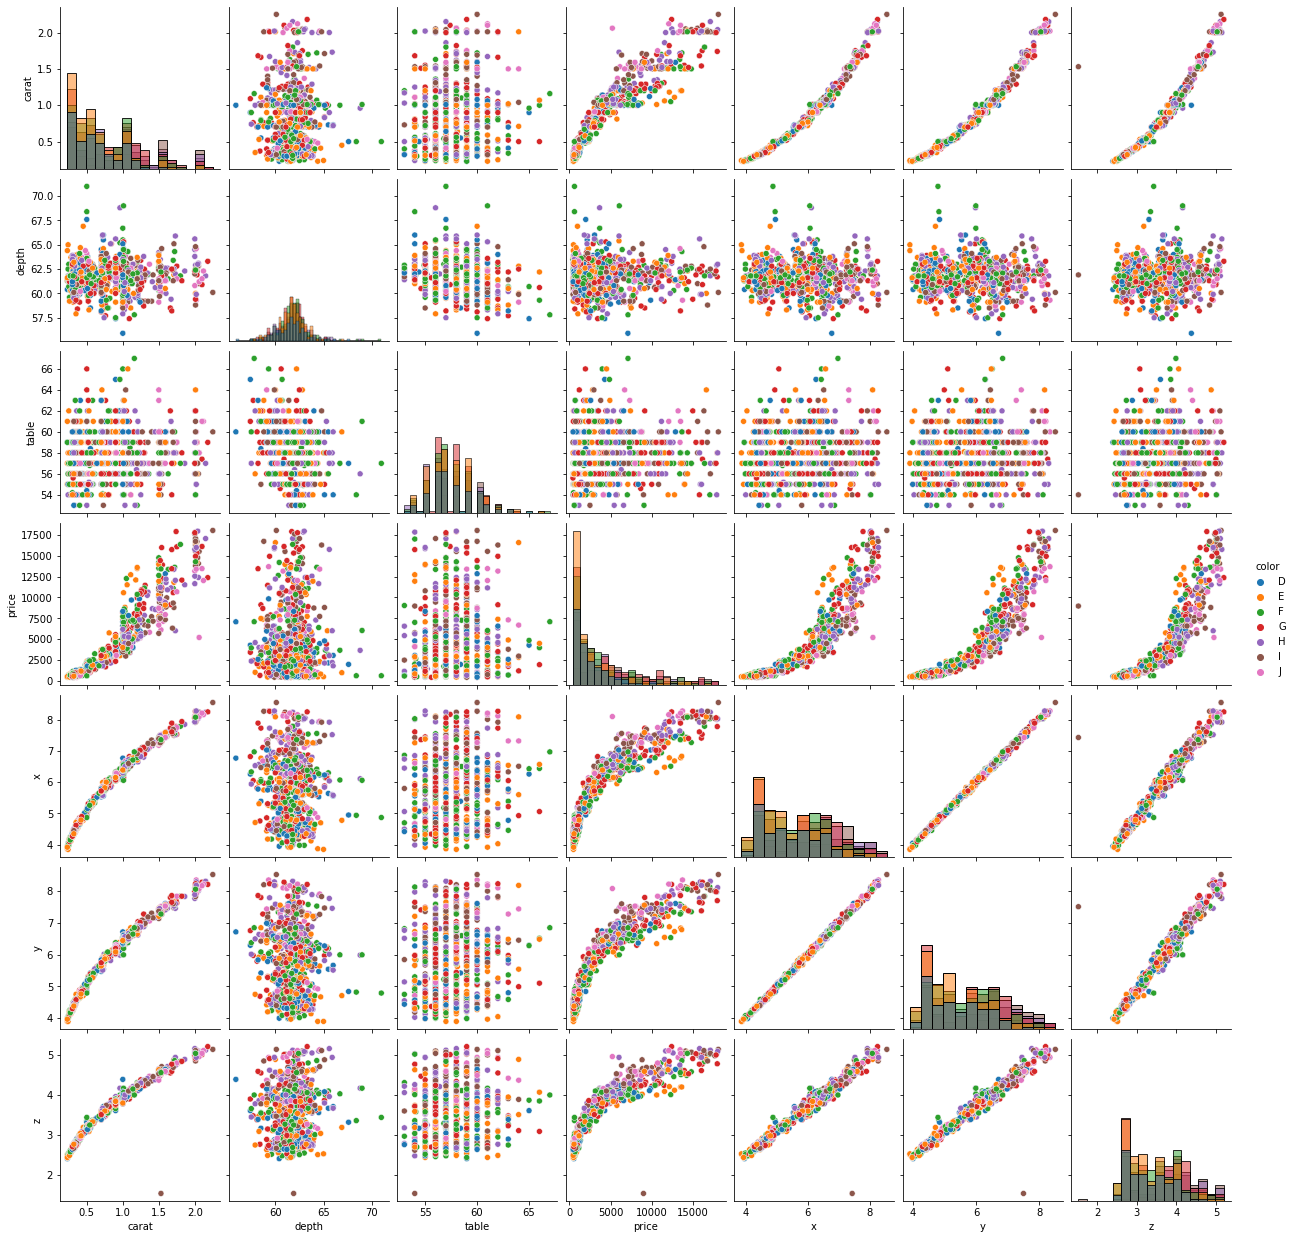

In [14]:
sns.pairplot(data.iloc[random_subset], hue='color', diag_kind='hist')
pass

Представить вместе и диаграмму рассеивания для пары признаков и соответствующие гистограммы:

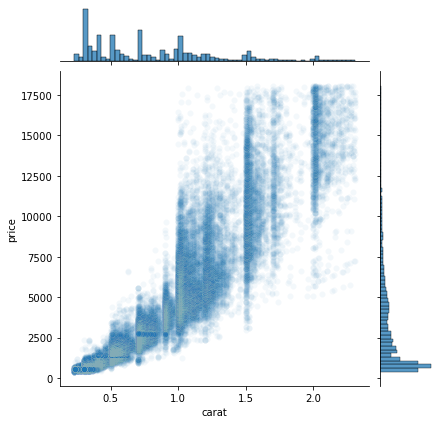

In [15]:
sns.jointplot(x='carat', y='price', alpha=.05, data=data)
pass

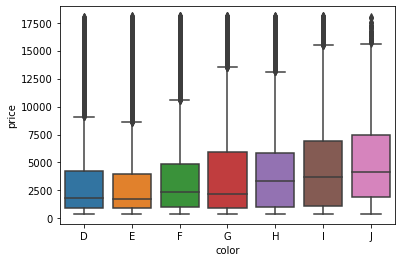

In [16]:
sns.boxplot(x="color", y="price", data=data)
pass

Можно вычислить матрицу корреляции для количественных признаков:

In [17]:
corr_mat = data.corr()
corr_mat

,carat,depth,table,price,x,y,z
carat,1.000000,0.025708,0.186148,0.921690,0.977600,0.952838,0.955494
depth,0.025708,1.000000,-0.294586,-0.011206,-0.027578,-0.031530,0.095194
table,0.186148,-0.294586,1.000000,0.128906,0.198465,0.186267,0.152947
price,0.921690,-0.011206,0.128906,1.000000,0.882608,0.862390,0.859634
x,0.977600,-0.027578,0.198465,0.882608,1.000000,0.973053,0.970138
y,0.952838,-0.031530,0.186267,0.862390,0.973053,1.000000,0.950168
z,0.955494,0.095194,0.152947,0.859634,0.970138,0.950168,1.000000


Удобно использовать визуальный образ этой матрицы. Чем светлее ячейка, тем больше по абсолютной величине коэффициент корреляции:

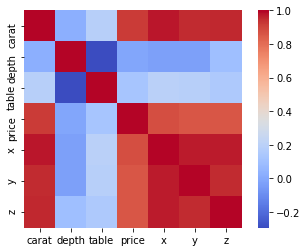

In [18]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Можно отметить зависимость между глубиной, высотой и шириной, а так же между ценой, числом карат и всеми тремя измерениями. Так же чем больше глубина алмаза, тем меньше будет размер его большей части.

Посмотрим сколько раз номинальные переменные принимают то или иное значение

In [19]:
data['cut'].value_counts()

Ideal        21336
Premium      13568
Very Good    11892
Good          4819
Fair          1569
Name: cut, dtype: int64

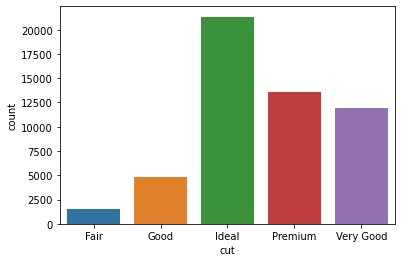

In [20]:
sns.countplot(x='cut', data=data)
pass

In [21]:
data['color'].value_counts()

G    11177
E     9725
F     9457
H     8152
D     6735
I     5281
J     2657
Name: color, dtype: int64

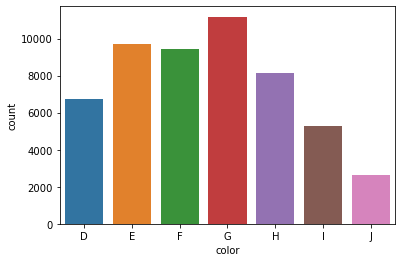

In [22]:
sns.countplot(x='color', data=data)
pass

In [23]:
data['clarity'].value_counts()

SI1     12893
VS2     12108
SI2      8935
VS1      8080
VVS2     5050
VVS1     3647
IF       1777
I1        694
Name: clarity, dtype: int64

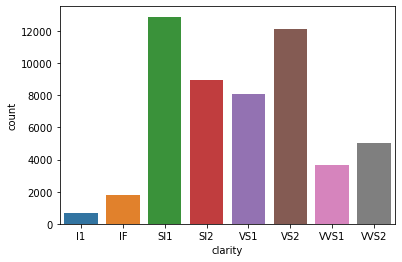

In [24]:
sns.countplot(x='clarity', data=data)
pass

## 4. Векторизация

Нужно что-то сделать с категориальными (номинальными) признаками

In [25]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'category']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'category']
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

[] ['cut', 'color', 'clarity']


К небинарными признакам применим метод векторизации, который заключается в следующем.
Например, в нашей задаче признак cut принимает 5 различных значений:

In [26]:
data['cut'].unique()

['Very Good', 'Good', 'Ideal', 'Premium', 'Fair']
Categories (5, object): ['Very Good', 'Good', 'Ideal', 'Premium', 'Fair']

Заменим признак cut 5 признаками: cut_Very Good, cut_Good, cut_Ideal, cut_Premium, cut_Fair.

- Если признак race принимает значение Very Good, то признак cut_Very Good равен 1, а все остальные равны 0.
- Если признак race принимает значение Good, то признак cut_Good равен 1, а все остальные равны 0. и т.д.

Такую векторизацию осуществляет в pandas метод get_dummies:

In [27]:
data[nonbinary_columns]

,cut,color,clarity
30,Very Good,F,VS1
31,Very Good,F,VS1
32,Very Good,E,VS1
33,Very Good,E,VS1
34,Very Good,D,VS1
...,...,...,...
53935,Ideal,D,SI1
53936,Good,D,SI1
53937,Very Good,D,SI1
53938,Premium,H,SI2


In [28]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['cut_Fair', 'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good',
       'color_D', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I',
       'color_J', 'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2',
       'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')


In [29]:
len(data_nonbinary.columns)

20

## 5. Нормализация качественных признаков

Многие алгоритмы машинного обучения чувствительны к масштабированию данных. К таким алгоритмам, например, относится метод ближайших соседей, машина опорных векторов и др.

В этом случае количественные признаки полезно нормализовать. Это можно делать разными способами. Например, каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению:

In [30]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,carat,depth,table,price,x,y,z
count,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000
mean,0.786504,61.748451,57.451384,3830.148466,5.713838,5.717375,3.528204
std,0.451083,1.427690,2.231588,3802.382623,1.092347,1.114457,0.687762
min,0.230000,43.000000,43.000000,402.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,955.000000,4.720000,4.730000,2.910000
50%,0.700000,61.800000,57.000000,2391.000000,5.690000,5.700000,3.520000
75%,1.040000,62.500000,59.000000,5241.000000,6.530000,6.520000,4.030000
max,2.310000,79.000000,95.000000,18077.000000,8.800000,58.900000,31.800000


In [31]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,carat,depth,table,price,x,y,z
count,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04
mean,3.962231e-14,4.968372e-13,-2.375612e-14,-1.281307e-15,8.863249e-14,2.172322e-13,-2.143969e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.233708e+00,-1.313202e+01,-6.475829e+00,-9.015790e-01,-5.230790e+00,-5.130189e+00,-5.129982e+00
25%,-8.568366e-01,-5.242390e-01,-6.503816e-01,-7.561439e-01,-9.098186e-01,-8.859698e-01,-8.988644e-01
50%,-1.917698e-01,3.610682e-02,-2.022702e-01,-3.784860e-01,-2.182239e-02,-1.559069e-02,-1.192906e-02
75%,5.619725e-01,5.264094e-01,6.939525e-01,3.710441e-01,7.471640e-01,7.201937e-01,7.296070e-01
max,3.377422e+00,1.208354e+01,1.682596e+01,3.746822e+00,2.825258e+00,4.772066e+01,4.110697e+01


## Соединяем всё в одну таблицу

In [32]:
data_normal = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data_normal.shape)

(53184, 27)


In [33]:
data_normal.describe()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
count,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,5.318400e+04,53184.000000,53184.000000,53184.000000,...,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000,53184.000000
mean,3.962231e-14,4.968372e-13,-2.375612e-14,-1.281307e-15,8.863249e-14,2.172322e-13,-2.143969e-13,0.029501,0.090610,0.401173,...,0.099297,0.049959,0.013049,0.033412,0.242423,0.168002,0.151925,0.227662,0.068573,0.094953
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.169209,0.287056,0.490141,...,0.299063,0.217862,0.113486,0.179712,0.428553,0.373871,0.358952,0.419328,0.252729,0.293153
min,-1.233708e+00,-1.313202e+01,-6.475829e+00,-9.015790e-01,-5.230790e+00,-5.130189e+00,-5.129982e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.568366e-01,-5.242390e-01,-6.503816e-01,-7.561439e-01,-9.098186e-01,-8.859698e-01,-8.988644e-01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.917698e-01,3.610682e-02,-2.022702e-01,-3.784860e-01,-2.182239e-02,-1.559069e-02,-1.192906e-02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.619725e-01,5.264094e-01,6.939525e-01,3.710441e-01,7.471640e-01,7.201937e-01,7.296070e-01,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.377422e+00,1.208354e+01,1.682596e+01,3.746822e+00,2.825258e+00,4.772066e+01,4.110697e+01,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## X и Y

In [34]:
X = data_normal.drop('color_D', axis = 1) # выбрасываем столбец 'color_D'
y = data['color']
feature_names = X.columns
feature_names

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut_Fair',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [35]:
X = X.to_numpy()

In [36]:
Y = np.array(y == "D"  , dtype='int')
Y

array([0, 0, 0, ..., 1, 0, 1])

In [37]:
print(X.shape)
print(Y.shape)
N, d = X.shape

(53184, 26)
(53184,)


In [38]:
type(Y)

numpy.ndarray

In [39]:
type(X)

numpy.ndarray

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

37228 15956


## ***k***NN

In [41]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 10)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [42]:
X_test[np.isnan(X_test)] = 0.0
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.02143394334419654

In [43]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.016922746319974213

In [44]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[13857    78]
 [  264  1757]]


In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 4)
#knn.set_params(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [46]:
X_test[np.isnan(X_test)] = 0.0
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.011531712208573578

In [47]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.007037713548941657

In [48]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[13895    40]
 [  144  1877]]


## Вывод

Как итог выполненной лабораторной рабоыт была решена задача классификации. Был предсказан уровень резки алмаза с малой ошибкой, посредством алгоритма ближайших соседей (KNN). При меньшем количестве соседей ошибка не уменьшалась, было рассмотрено 4 и 10 соседей, минимальная ошибка была при 10. Также обратим внимание, что ошибка на тестовой выборке больше, чем на обучающей.